In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

/home/kdd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kdd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kdd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kdd/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

2.0.0-beta1
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.18.1
pandas 0.24.1
sklearn 0.21.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
%ls data/

csv/  eval.csv  tfrecord/  tfrecord_zip/  train.csv


In [3]:
train_file = './data/train.csv'
eval_file = './data/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [4]:
print(train_df.head(1))
print(eval_df.head(1))

   survived   sex   age  n_siblings_spouses  parch  fare  class     deck  \
0         0  male  22.0                   1      0  7.25  Third  unknown   

   embark_town alone  
0  Southampton     n  
   survived   sex   age  n_siblings_spouses  parch  fare  class     deck  \
0         0  male  35.0                   0      0  8.05  Third  unknown   

   embark_town alone  
0  Southampton     y  


In [5]:
train_df.describe()

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [6]:
train_df.shape, eval_df.shape

((627, 10), (264, 10))

In [7]:
train_df.columns

Index(['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare',
       'class', 'deck', 'embark_town', 'alone'],
      dtype='object')

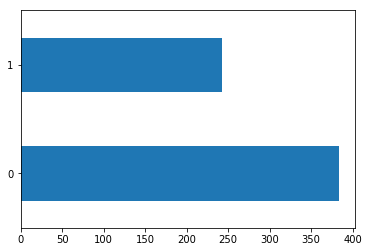

In [8]:
train_df.survived.value_counts().plot(kind='barh')

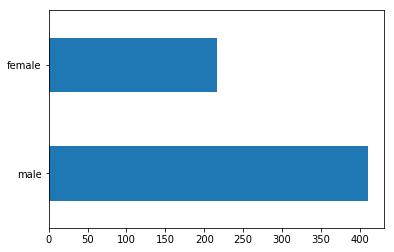

In [9]:
train_df.sex.value_counts().plot(kind='barh')

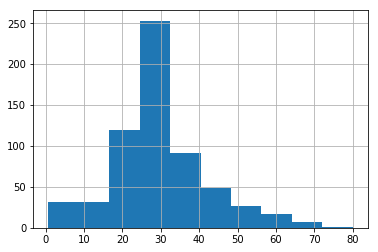

In [10]:
train_df.age.hist(bins=10)

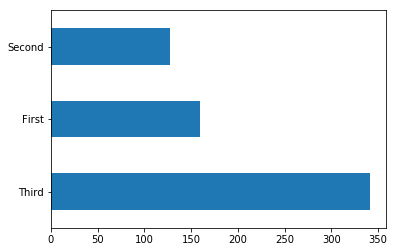

In [11]:
train_df['class'].value_counts().plot(kind='barh')

In [12]:
train_df.groupby('sex').survived.count()

sex
female    217
male      410
Name: survived, dtype: int64

In [13]:
train_df.groupby('sex').survived.mean()

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64

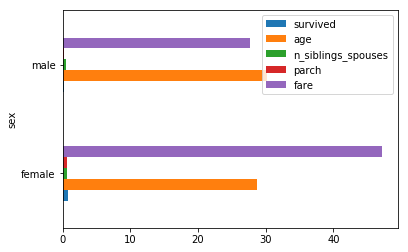

In [14]:
train_df.groupby('sex').mean().plot(kind='barh')

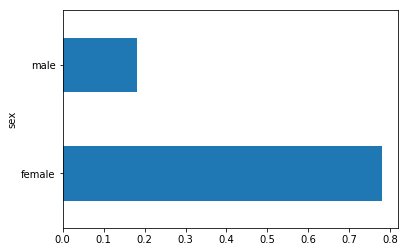

In [15]:
train_df.groupby('sex').survived.mean().plot(kind='barh')

In [16]:
y_trian = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [18]:
train_df.shape, eval_df.shape

((627, 9), (264, 9))

In [20]:
categorical_columns = ['sex', 'parch', 'class', 'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'n_siblings_spouses', 'fare']
feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    categ_col = tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab)
    categ_col = tf.feature_column.indicator_column(categ_col)
    feature_columns.append(categ_col)
    
for numeric_column in numeric_columns:
    numeric_column = tf.feature_column.numeric_column(numeric_column, dtype=tf.float32)
    feature_columns.append(numeric_column)

sex ['male' 'female']
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [21]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategorica

In [23]:
def df_to_dataset(feature, target, epochs=10, shuffle=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(feature), target))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(feature))
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset
        

In [25]:
train_dataset = df_to_dataset(train_df, y_trian, batch_size=3)
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=41863, shape=(3,), dtype=string, numpy=array([b'male', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: id=41855, shape=(3,), dtype=float64, numpy=array([ 9., 18., 36.])>, 'n_siblings_spouses': <tf.Tensor: id=41861, shape=(3,), dtype=int32, numpy=array([5, 1, 0], dtype=int32)>, 'parch': <tf.Tensor: id=41862, shape=(3,), dtype=int32, numpy=array([2, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=41860, shape=(3,), dtype=float64, numpy=array([46.9  , 17.8  , 12.875])>, 'class': <tf.Tensor: id=41857, shape=(3,), dtype=string, numpy=array([b'Third', b'Third', b'Second'], dtype=object)>, 'deck': <tf.Tensor: id=41858, shape=(3,), dtype=string, numpy=array([b'unknown', b'unknown', b'D'], dtype=object)>, 'embark_town': <tf.Tensor: id=41859, shape=(3,), dtype=string, numpy=array([b'Southampton', b'Southampton', b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: id=41856, shape=(3,), dtype=string, numpy=array([b'n', b'n', b'y'], dtype=object)>} tf.Tensor([0 0 0], sha

In [26]:
for x, y in train_dataset.take(1):
    age_col = feature_columns[7]
    gender_col = feature_columns[0]
    print(keras.layers.DenseFeatures(age_col)(x))
    print(keras.layers.DenseFeatures(gender_col)(x))

tf.Tensor(
[[5.]
 [1.]
 [0.]], shape=(3, 1), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]], shape=(3, 2), dtype=float32)


In [30]:
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x))

tf.Tensor(
[[ 9.     1.     0.     1.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    46.9    5.
   0.     0.     1.     0.     0.     0.     1.     0.   ]
 [18.     1.     0.     1.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    17.8    1.
   1.     0.     0.     0.     0.     0.     0.     1.   ]
 [36.     0.     1.     0.     0.     1.     0.     0.     0.     0.
   0.     1.     0.     0.     0.     1.     0.     0.    12.875  0.
   1.     0.     0.     0.     0.     0.     1.     0.   ]], shape=(3, 28), dtype=float32)


In [31]:
train_dataset = df_to_dataset(train_df, y_trian, epochs=100)
eval_dataset = df_to_dataset(eval_df, y_eval, epochs=1)

In [36]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(learning_rate=0.01),
             metrics=['accuracy'])

In [37]:
history = model.fit(train_dataset, validation_data=eval_dataset, steps_per_epoch=len(train_df) // 32,
                   validation_steps = len(eval_df) // 32, epochs=100)

Epoch 1/100
19/19 [==============================] - 1s 65ms/step - loss: 2.3075 - accuracy: 0.5300 - val_loss: 0.7615 - val_accuracy: 0.6250
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.8421 - accuracy: 0.6689 - val_loss: 0.5965 - val_accuracy: 0.7227
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.7838 - accuracy: 0.6182 - val_loss: 0.5899 - val_accuracy: 0.7031
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5960 - accuracy: 0.7085 - val_loss: 0.5890 - val_accuracy: 0.7109
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.6434 - accuracy: 0.6691 - val_loss: 0.5830 - val_accuracy: 0.7188
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5937 - accuracy: 0.7068 - val_loss: 0.6291 - val_accuracy: 0.6641
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.6289 - accuracy: 0.6919 - val_loss: 0.5961 - val_accuracy: 0.7227
Epoch 8/100


Epoch 51/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5614 - accuracy: 0.7697 - val_loss: 0.7254 - val_accuracy: 0.6523
Epoch 52/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5565 - accuracy: 0.7237 - val_loss: 0.5145 - val_accuracy: 0.7383
Epoch 53/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7828 - val_loss: 0.5075 - val_accuracy: 0.7383
Epoch 54/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5307 - accuracy: 0.7598 - val_loss: 0.5209 - val_accuracy: 0.7383
Epoch 55/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5516 - accuracy: 0.7374 - val_loss: 0.5924 - val_accuracy: 0.7188
Epoch 56/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5218 - accuracy: 0.7552 - val_loss: 0.5056 - val_accuracy: 0.7578
Epoch 57/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5642 - accuracy: 0.7384 - val_loss: 0.5176 - val_accuracy: 0.7500
Epoch 

In [38]:
estimator = keras.estimator.model_to_estimator(model)
estimator.train(input_fn=lambda : df_to_dataset(train_df, y_trian, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3stp3ktf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f13ac38f240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True

KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_5', 'input_6', 'input_9', 'input_3', 'input_7', 'input_8', 'input_1', 'input_2', 'input_4'}\n\tfeatures keys: {'n_siblings_spouses', 'sex', 'alone', 'fare', 'embark_town', 'deck', 'class', 'age', 'parch'}\n\tDifference: {'input_5', 'input_6', 'n_siblings_spouses', 'sex', 'alone', 'fare', 'input_9', 'embark_town', 'age', 'class', 'input_3', 'input_7', 'deck', 'input_8', 'input_1', 'parch', 'input_2', 'input_4'}"